<a href="https://colab.research.google.com/github/kmswin1/Pytorch-Study/blob/master/Week3_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5c33e000 @  0x7fad64f142a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# 본인의 구글 드라이브와 연동하는 과정 1
# 실행 후 밑에 나오는 링크에 들어가서 나오는 코드를 밑에 입력
# Downloaded content "Sample upload file content" 라는 메시지가 나오면 OK

# (런타임을 재시작한 경우) 아무 메시지 없이 계속 기다리는 상황이 있는데, 밑에 생기는 네모 빈 칸에 엔터 입력

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Uploaded file with ID 11CYMDsJXQCNzz8EWf6AFY3yV0MEEg6fa
Downloaded content "Sample upload file content"


In [0]:
# 본인의 구글 드라이브와 연동하는 과정 2
# 실행 후 밑에 나오는 링크에 들어가서 나오는 코드를 밑에 입력
# Please enter the verification code: Access token retrieved correctly. 라는 메시지가 나오면 OK

# (런타임을 재시작한 경우) 아무 메시지 없이 계속 기다리는 상황이 있는데, 밑에 생기는 네모 빈 칸에 엔터 입력
# fuse: mountpoint is not empty
# fuse: if you are sure this is safe, use the 'nonempty' mount option
# 라는 메시지가 나오면 그냥 무시

# 또한 필요한 라이브러리를 설치
# 좀 시간이 걸림

!apt-get update > /dev/null
!apt-get install -y -qq software-properties-common  module-init-tools g++ > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
import os
import sys
import timeit
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('scipy version : ', sp.__version__)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
numpy version :  1.14.6
scipy version :  1.1.0
matplotlib version : 3.0.2
pytorch version :  0.4.0
Cuda :  True


In [0]:
!ls ./drive/2019_pytorch_study

'2019 winter pytorch tutorial.odt'   data   notebook  '스터디 시간 조사.ods'


In [0]:
!ls ./drive/2019_pytorch_study/data/
!ls ./drive/2019_pytorch_study/data/seq2seq
!ls ./drive/2019_pytorch_study/data/seq2seq/names

seq2seq
eng-fra.txt  names
Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 참고

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

# SOS : Start of sequence
# EOS : End of sequence
SOS_token = 0
EOS_token = 1

class Lang:
    
    def __init__(self, name):
        
        self.name = name
        self.word2index = {} 
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"} 
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        
        for word in sentence.split(' '):
            
            self.addWord(word)

    def addWord(self, word):
        
        if word not in self.word2index:
            
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            
            self.word2count[word] += 1
            
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
# NFD : Normalization Form Canonical Decomposition
def unicodeToAscii(s):
    
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    return s

def readLangs(lang1, lang2, reverse = False):
    
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./drive/2019_pytorch_study/data/seq2seq/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        
    else:
        
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10 # attention model 을 위한 상수

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    
    # \ 는 코드 줄내림을 의미
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse = False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    for pair in pairs:
        
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elle est une artiste nee .', 'she is a gifted artist .']


In [0]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # input size 는 입력 language 의 단어 dictionary size, hidden size 로 embedding dim 을 정함
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Embedding 을 거쳐 나오는 벡터를 input 으로 받아서 GRU 의 input dim 도 hidden size 임
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden) # output 은 embedding 된 input vector, hidden 은 hidden state vector
        
        return output, hidden

    def initHidden(self):
        
        return torch.zeros(1, 1, self.hidden_size, device = device)

In [0]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size

        # 디코더는 output language 의 dictionary size 를 output size 로 사용 (처음에 output language 의 SOS 가 들어오는 상황을 생각)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        # dictionary 에서 가장 적절한 단어를 classification 하는 것
        self.out = nn.Linear(hidden_size, output_size)
        # LogSoftmax 를 쓰면 NLLLoss 를 씀
        self.softmax = nn.LogSoftmax(dim = 1) # cross entropy

    def forward(self, input, hidden):
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

    def initHidden(self):
        
        return torch.zeros(1, 1, self.hidden_size, device = device)
    
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length = MAX_LENGTH):
        
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        # 어텐션은 hidden state 를 linear combination 하는 것이고, 그것을 위한 계수 개수를 고정해야 함
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # 하나의 hidden size 는 embedding 한 input sequence 의 것이고, 나머지 하나는 hidden state 의 것
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # 위에서 이야기한 계수가 이것, 보통 얘를 attention vector 라고 함, sum to one
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim = 1)
        # bmm : batch matrix-matrix product
        # b1.size() == (b, n, m) 이고 b2.size() == (b, m, p) 이면, 결과는 (b, n, p) 임
        # encoder 에서 나온 정보를 linear combination 하는 것
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # encoder 에서 가져온 정보를 input word vector 와 잘 섞음
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim = 1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        
        return torch.zeros(1, 1, self.hidden_size, device = device)

In [0]:
import time
import math

def asMinutes(s):
    
    m = math.floor(s / 60)
    s -= m * 60
    
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def indexesFromSentence(lang, sentence):
    
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype = torch.long, device = device).view(-1, 1)

def tensorsFromPair(pair):
    
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # attention 을 구할 때 사용할 정보를 담을 공간
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

    loss = 0

    for ei in range(input_length):
        
        # 여기선 encoder 의 output vector 를 attention 을 통해 decoder 에 줌
        # encoder 의 hidden state vector 를 attention 을 통해 decoder 에 줄 수도 있음
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device = device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def trainIters(encoder, decoder, n_iters, print_every = 1000, plot_every = 100, learning_rate = 0.01):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        
        # 1 부터 시작해서 표현이 그럼
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

2m 19s (- 32m 38s) (5000 6%) 2.8396
4m 35s (- 29m 53s) (10000 13%) 2.2857
6m 51s (- 27m 26s) (15000 20%) 1.9418
9m 9s (- 25m 10s) (20000 26%) 1.7331
11m 26s (- 22m 52s) (25000 33%) 1.5016
13m 44s (- 20m 36s) (30000 40%) 1.3367
16m 1s (- 18m 18s) (35000 46%) 1.1995
18m 18s (- 16m 1s) (40000 53%) 1.0794
20m 37s (- 13m 45s) (45000 60%) 0.9410
22m 55s (- 11m 27s) (50000 66%) 0.8828
25m 13s (- 9m 10s) (55000 73%) 0.7912
27m 31s (- 6m 52s) (60000 80%) 0.7561
29m 49s (- 4m 35s) (65000 86%) 0.6642
32m 7s (- 2m 17s) (70000 93%) 0.5850
34m 26s (- 0m 0s) (75000 100%) 0.5461


<Figure size 432x288 with 0 Axes>

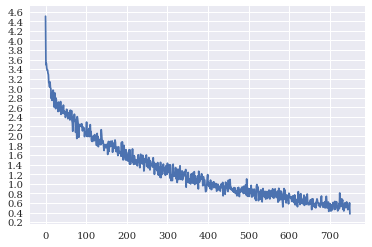

In [0]:
hidden_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [0]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes cerne .
= you re surrounded .
< you re surrounded . <EOS>

> je vous le demande en tant qu amie .
= i m asking you as a friend .
< i m asking you as a friend . <EOS>

> nous avons des problemes avec notre nouveau voisin .
= we are having trouble with our new neighbor .
< we are having trouble with our new neighbor . <EOS>

> tu n es pas aussi petit que moi .
= you aren t as short as me .
< you aren t as short as i . <EOS>

> je suis en conge cette semaine .
= i am on holiday this week .
< i am on this this week . <EOS>

> je n en suis pas fier .
= i am not proud of this .
< i m not proud of it . <EOS>

> nous n en avons pas fini .
= we re not done .
< we re not done . <EOS>

> je n en ai pas fini avec lui .
= i m not finished with him .
< i m not finished with him . <EOS>

> ce ne sont que des mots .
= they re just words .
< they re just words . <EOS>

> je suis sur que que c est mal .
= i m sure that s wrong .
< i m sure that he s a . <EOS>



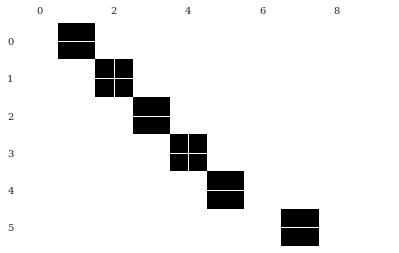

In [0]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . . <EOS>


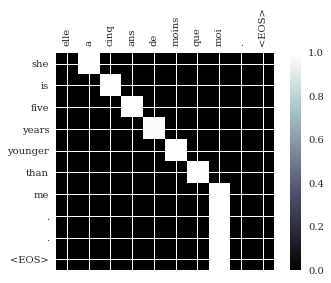

input = elle est trop petit .
output = she s too hard . <EOS>


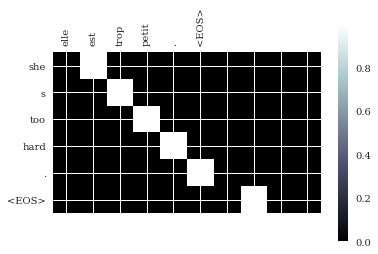

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


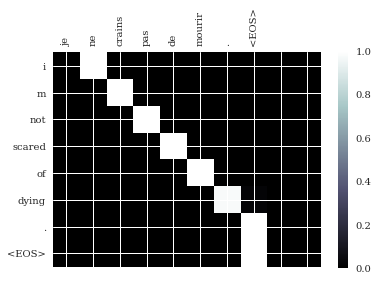

input = c est un jeune directeur plein de talent .
output = he s a talented young . <EOS>


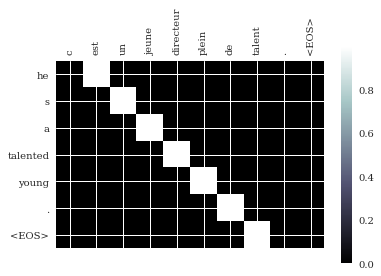

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")